# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import random
import os

from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Прочитаме и сохраним данные под переменной labels

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Изучим данные датасета, выведем: общую информацию, 5 первых строк, основные статистические данные. Проверим на наличие дубликатов.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
labels.duplicated().sum()

0

Построим гистограмму распределения данных по возрасту

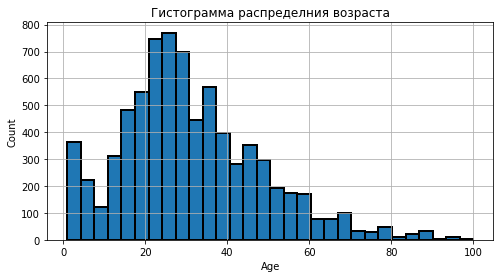

In [8]:
labels.real_age.hist(bins=30, edgecolor='black', linewidth=2, figsize=(8, 4))
plt.title('Гистограмма распределния возраста')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Загрузим фотографии из папки '/datasets/faces/final_files/' с привязкой к датасету находящемуся '/datasets/faces/labels.csv'. 

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Выведем 15 фотографийуказав возраст.

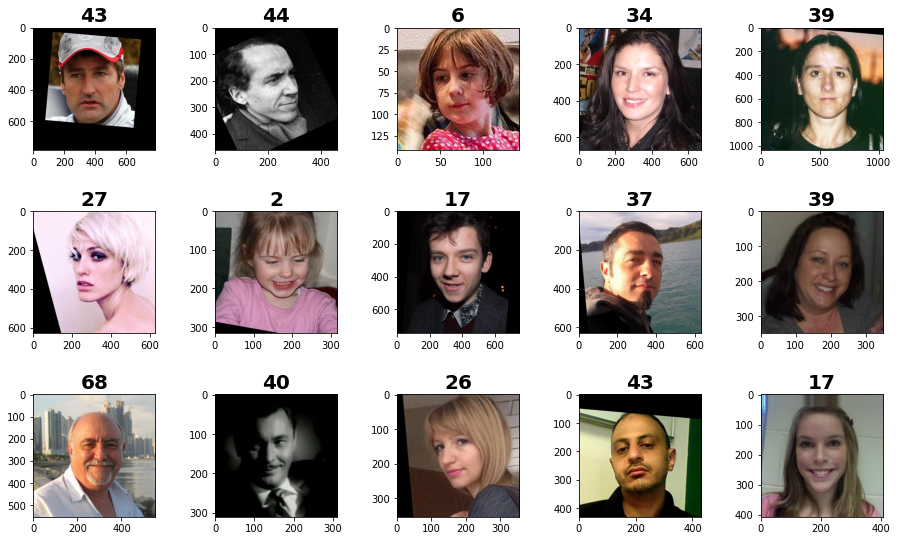

In [67]:
src_path = '/datasets/faces/final_files/'
sub_class = os.listdir(src_path)
labels_index = labels.set_index('file_name')

fig = plt.figure(figsize=(16, 9))
for e in range(len(sub_class[:15])):
    plt.subplot(3, 5, e+1)
    img = plt.imread(os.path.join(src_path, sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.title(labels_index['real_age'].loc[sub_class[e]],
              fontsize= 20, fontweight='bold')

**Данные содержат 7591 фотографию людей в возрастной категории от 1 до 100 лет. Гистограмма показывает скошенное влево распределений возраста. 50% датасета приходится на возрастную категорию от 20 до 41 года. В возрасте от 60 до 100 лет представлены значительно меньшим количеством, что может отрицательно сказаться на качестве предсказания модели в этом диапазоне. Присутствие фотографий в профиль, плохого качества, черно-белых также повлиет на качество предсказания модели в худшую сторону.**

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

 def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        zoom_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.05,
        horizontal_flip=True,
        validation_split=0.25,
        rescale=1./255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model

    

def train_model(model, train_data, test_data, 
                batch_size=None,
                epochs=15,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

 
```

**Результат вывода модели**

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-07-30 15:30:51.045633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-30 15:30:51.651100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 123s - loss: 453.3771 - mae: 16.0289 - val_loss: 894.6155 - val_mae: 25.0335
Epoch 2/15
178/178 - 115s - loss: 107.5431 - mae: 7.7848 - val_loss: 850.1852 - val_mae: 24.2477
Epoch 3/15
178/178 - 109s - loss: 88.0157 - mae: 7.0889 - val_loss: 532.1809 - val_mae: 17.7627
Epoch 4/15
178/178 - 110s - loss: 71.6836 - mae: 6.4476 - val_loss: 169.9400 - val_mae: 9.8315
Epoch 5/15
178/178 - 110s - loss: 63.8987 - mae: 6.0581 - val_loss: 87.4857 - val_mae: 7.0277
Epoch 6/15
178/178 - 110s - loss: 53.5087 - mae: 5.5733 - val_loss: 70.5662 - val_mae: 6.3703
Epoch 7/15
178/178 - 109s - loss: 47.4688 - mae: 5.2838 - val_loss: 73.0956 - val_mae: 6.3173
Epoch 8/15
178/178 - 114s - loss: 41.6405 - mae: 4.9691 - val_loss: 66.4217 - val_mae: 6.0686
Epoch 9/15
178/178 - 115s - loss: 39.9419 - mae: 4.8768 - val_loss: 85.2185 - val_mae: 6.8712
Epoch 10/15
178/178 - 114s - loss: 36.8746 - mae: 4.6549 - val_loss: 64.9399 - val_mae: 6.0636
Epoch 11/15
178/178 - 113s - loss: 35.1759 - mae: 4.5645 - val_loss: 76.4186 - val_mae: 6.4491
Epoch 12/15
178/178 - 112s - loss: 32.4614 - mae: 4.3934 - val_loss: 70.7596 - val_mae: 6.4839
Epoch 13/15
178/178 - 114s - loss: 28.3848 - mae: 4.1154 - val_loss: 87.0613 - val_mae: 6.6668
Epoch 14/15
178/178 - 113s - loss: 27.8753 - mae: 4.0946 - val_loss: 81.7657 - val_mae: 6.7944
Epoch 15/15
178/178 - 113s - loss: 25.9057 - mae: 3.9243 - val_loss: 63.9389 - val_mae: 5.9410
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 63.9389 - mae: 5.9410
Test MAE: 5.9410
```



## Анализ обученной модели

**Достигнуто предсказание модели с MAE чуть меньше 6 лет. Данная ошибка допустима для анализа покупок и предложения товаров, в отличии от контроля продажи алкоголя. НО, учитывая хорошее качество съемки камерой магазина в анфас и при наличии соответствующего набора данных можно достичь метрик намного лучше, что позволит внедрить данную технологию в полном объеме.**